In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

In [26]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the first column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # Strip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break  # Stop reading lines after finding column names
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)

    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d

In [27]:
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        d.append(reader(paths[i], first_var))
    d = pd.concat(d).reset_index()
    return d

In [28]:
s_p = reader('../data/DASH_test_240516/DASH_SAMP_PARAM_240516_175450.dat', first_var='#StartTimeSt')
dopc = glob_reader('OPC_210', '#YY/MM/DD', subfolder = '../data/DASH_test_240516/')
hopc = glob_reader('OPC_212', '#YY/MM/DD', subfolder = '../data/DASH_test_240516/')

In [29]:
s_p.keys()

Index(['StartTimeSt', 'EndTimeSt', 'StartYr', 'EndYr', 'StartSecs', 'EndSecs',
       'Samp_Num', 'DO_Tot_Cnts', 'HO_Tot_Cnts', 'DO_Mode_Val', 'HO_Mode_Val',
       'UpSt_Dia', 'UpSt_Sh_Targ', 'RH_Targ', 'HO_Rh_Av', 'HO_Rh_Sdev',
       'HM_RH_Av', 'HM_Rh_Sdev', 'DO_Sh_Targ', 'DO_Sh_Av', 'DO_Sh_Sdev',
       'DO_Samp_Targ', 'DO_Samp_Av', 'DO_Samp_Sdev', 'HO_Sh_Targ', 'HO_Sh_Av',
       'HO_Sh_Sdev', 'HO_Samp_Targ', 'HO_Samp_Av', 'HO_Samp_Sdev',
       'HM_Sh_Targ', 'HM_Sh_Av', 'HM_Sh_Sdev', 'HM_Xs_Targ', 'HM_Xs_Av',
       'HM_Xs_Sdev', 'Samp_Xs_Targ', 'Samp_Xs_Av', 'Samp_Xs_Sdev', 'st_dt',
       'end_dt'],
      dtype='object')

In [30]:
st = s_p.loc[0,'st_dt']
end = s_p.loc[len(s_p)-1,'end_dt']

In [31]:
# crop OPC data
dopc_c = dopc[(dopc['dt']>=st) & (dopc['dt']<=end)]
hopc_c = hopc[(hopc['dt']>=st) & (hopc['dt']<=end)]

In [32]:
def add_bin_sum(d):
    d = d.copy()
    col_w_bin = [col for col in dopc.columns if 'bin' in col]
    d['bin_sum'] = d[col_w_bin].sum(numeric_only = True, axis=1)
    return d

In [33]:
dopc_c = add_bin_sum(dopc_c)
hopc_c = add_bin_sum(hopc_c)

In [34]:
def log_norm3(D, N, dg, sigma, N2, dg2, sigma2, N3, dg3, sigma3):
    output = N/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    output += N2/((2*np.pi)**.5 * np.log(sigma2))*np.exp(-(np.log(D)-np.log(dg2))**2/(2*(np.log(sigma2))**2))
    output += N3/((2*np.pi)**.5 * np.log(sigma3))*np.exp(-(np.log(D)-np.log(dg3))**2/(2*(np.log(sigma3))**2))
    return output

def log_norm2(D, N, dg, sigma, N2, dg2, sigma2):
    output = N/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    output += N2/((2*np.pi)**.5 * np.log(sigma2))*np.exp(-(np.log(D)-np.log(dg2))**2/(2*(np.log(sigma2))**2))
    return output

def log_norm1(D, N, dg, sigma):
    output = N/((2*np.pi)**.5 * np.log(sigma))*np.exp(-(np.log(D)-np.log(dg))**2/(2*(np.log(sigma))**2))
    return output

def within_threshold_optimized(arr, threshold):
    """
    Optimized check if any two values in the array are within the specified threshold of each other.

    Parameters:
    arr (numpy array or list): The array to check.
    threshold (float): The threshold value.

    Returns:
    bool: True if any two values are within the threshold, False otherwise.
    """
    arr = np.sort(np.array(arr))
    n = len(arr)
    for i in range(n - 1):
        if abs(arr[i] - arr[i + 1]) <= threshold:
            return True
    return False


numbers_str = '155.0	158.1	161.2	164.5	167.7	171.1	174.5	178.0	181.5	185.2	188.8	192.6	196.5	200.4	204.4	208.4	212.6	216.8	221.2	225.6	230.1	234.7	239.4	244.1	249.0	254.0	259.0	264.2	269.5	274.8	280.3	285.9	291.6	297.4	303.4	309.4	315.6	321.9	328.3	334.9	341.5	348.4	355.3	362.4	369.6	377.0	384.5	392.2	400.0	408.8	420.7	437.7	461.3	492.6	532.4	580.7	637.5	702.3	773.7	852.3	939.0	1034.4	1139.5	1255.3	1382.9	1523.5	1678.3	1848.9	2036.9	2243.9	2472.0	2723.2	3000.0'
Dp = np.array([float(x) for x in numbers_str.split()])
Dp = Dp[:-1]

def summer(d, dp_max = 3000.0):
    Dp_i = Dp[Dp<dp_max]
    m_c = []
    w_m = []
    w_m2 = []
    w_m3 = []
    col_w_bin = [col for col in dopc.columns if 'bin' in col][0:len(Dp_i)]
    fig,ax = plt.subplots(2, sharex='all')
    for i in tqdm(range(0, len(d))):
        m_c.append(d['bin_sum'].iloc[0:i+1].sum())
        sig = np.array(d[col_w_bin].iloc[0:i+1].sum())
        ax[0].plot(Dp_i, sig)
        ax[1].set_xscale('log')
        ax[1].set_xlabel('OPC Estimated D$_p$')
        ax[1].set_ylabel('$dn_p/d\log D_p$ [cm$^{-3}$]')
        ax[0].set_ylabel('$dn_p/d\log D_p$ [cm$^{-3}$]')
        #plt.xlim([0,300])
        #w_m.append(((sig*Dp_i).sum()/(sig).sum()))
        #w_m.append(np.average(Dp_i, weights = sig))
        try:
            popt, pcov = curve_fit(log_norm3, Dp_i, sig, p0=[200, 200, 1.5, 200, 200, 1.5, 200, 200, 1.5], bounds=([0,50,0,0,50,0,0,50,0], [np.inf, 5000, np.inf, np.inf, 5000, np.inf, np.inf, 5000, np.inf]))
            N = np.array([popt[0],popt[3],popt[6]])
            D = np.array([popt[1],popt[4],popt[7]])
            if within_threshold_optimized(D, 15):
                1/0
            w_m.append(D[N.argmax()])
            w_m3.append(D[N.argmin()])
            w_m2.append(float(D[(D!=w_m[-1]) & (D!=w_m3[-1])]))
            ax[1].plot(Dp_i, log_norm3(Dp_i, *popt))
        except:
            try:
                popt, pcov = curve_fit(log_norm2, Dp_i, sig, p0=[200, 200, 1.5, 200, 200, 1.5], bounds=([0,50,0,0,50,0], [np.inf, 5000, np.inf, np.inf, 5000, np.inf]))
                N = np.array([popt[0],popt[3]])
                D = np.array([popt[1],popt[4]])
                if within_threshold_optimized(D, 15):
                    1/0
                w_m.append(D[N.argmax()])
                w_m2.append(D[N.argmin()])
                w_m3.append(np.nan)
                ax[1].plot(Dp_i, log_norm2(Dp_i, *popt))
            except:
                try:
                    popt, pcov = curve_fit(log_norm1, Dp_i, sig, p0=[200, 200, 1.5], bounds=([0,50,0], [np.inf, 5000, np.inf]))
                    w_m.append(popt[1])
                    w_m2.append(np.nan)
                    w_m3.append(np.nan)
                    ax[1].plot(Dp_i, log_norm1(Dp_i, *popt))
                except:
                    w_m.append(np.nan)
                    w_m2.append(np.nan)
                    w_m3.append(np.nan)

    fig.savefig('../figures/fits.png', dpi=300)
    return m_c, w_m, w_m2, w_m3

100%|██████████| 454/454 [00:37<00:00, 12.13it/s]


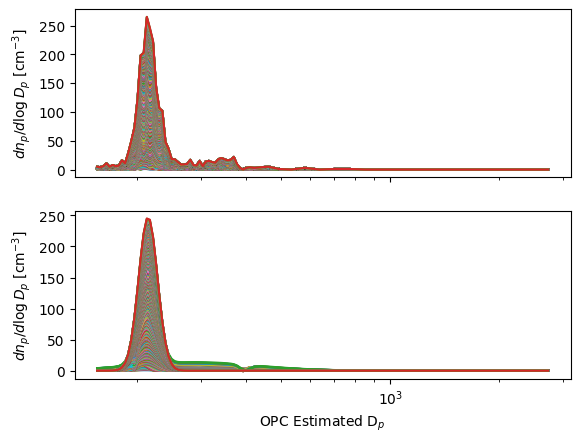

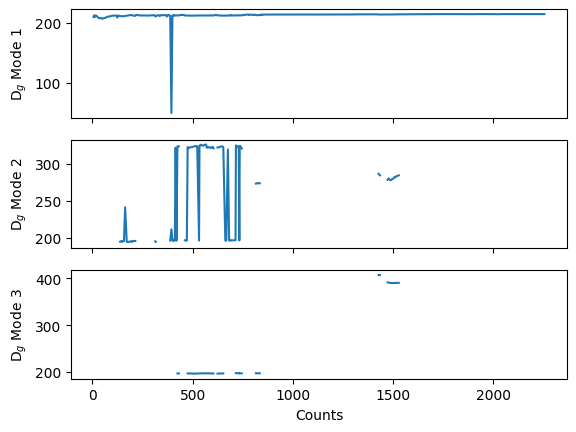

In [35]:
output = summer(dopc_c, dp_max=3000)
fig,ax = plt.subplots(3, sharex='all')
ax[0].plot(output[0],output[1])
ax[1].plot(output[0],output[2])
ax[2].plot(output[0],output[3])
ax[2].set_xlabel('Counts')
ax[0].set_ylabel('D$_g$ Mode 1')
ax[1].set_ylabel('D$_g$ Mode 2')
ax[2].set_ylabel('D$_g$ Mode 3')
plt.savefig('../figures/optimal_n_dopc.png', dpi=300)

100%|██████████| 453/453 [00:55<00:00,  8.15it/s]


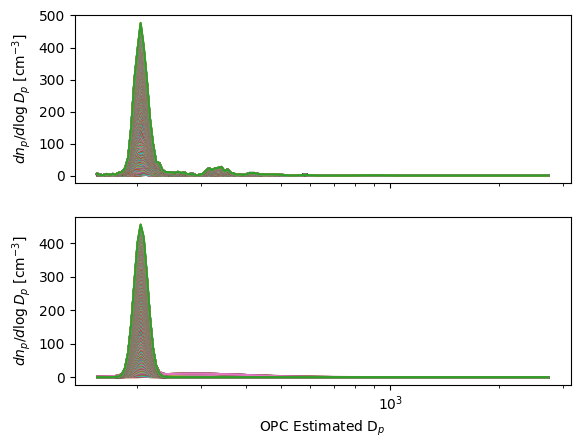

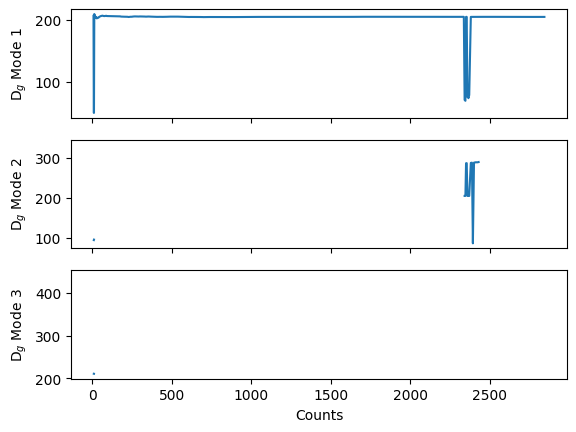

In [36]:
output = summer(hopc_c, dp_max=3000)
fig,ax = plt.subplots(3, sharex='all')
ax[0].plot(output[0],output[1])
ax[1].plot(output[0],output[2])
ax[2].plot(output[0],output[3])
ax[2].set_xlabel('Counts')
ax[0].set_ylabel('D$_g$ Mode 1')
ax[1].set_ylabel('D$_g$ Mode 2')
ax[2].set_ylabel('D$_g$ Mode 3')
plt.savefig('../figures/optimal_n_hopc.png', dpi=300)